平滑算子

In [30]:
import numpy as np
from matplotlib import pyplot as plt

data = np.loadtxt('data/Penobscot_HorB.txt')
print(data[:10])

[[ 1003.          1010.           926.39195919]
 [ 1003.          1011.           925.13644695]
 [ 1003.          1012.           924.19928312]
 [ 1003.          1013.           923.78389835]
 [ 1003.          1014.           923.74902964]
 [ 1003.          1015.           923.5907793 ]
 [ 1003.          1016.           923.72643948]
 [ 1003.          1017.           923.48623276]
 [ 1003.          1018.           923.40993881]
 [ 1003.          1019.           922.38986492]]


我们有了 inline, xline 和双程走时！



In [4]:
inlines = 1597 - 1003 + 1
xlines = 1471 - 1009 + 1

print(inlines, "inlines")
print(xlines, "crosslines")

595 inlines
463 crosslines


我们期望获得一个595行，464列的数组数据。


In [31]:
data[:,0] = inlines - (data[:, 0] - 1002)

data[:, 1] -= 1008

data[:5]

array([[ 594.        ,    2.        ,  926.39195919],
       [ 594.        ,    3.        ,  925.13644695],
       [ 594.        ,    4.        ,  924.19928312],
       [ 594.        ,    5.        ,  923.78389835],
       [ 594.        ,    6.        ,  923.74902964]])

In [15]:
horizon = np.empty((inlines, xlines))
print(horizon)
print(horizon.shape)

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
(595, 463)


In [34]:
for sample in data:
    inline = sample[0]
    xline = sample[1]
    z_value = sample[2]
    
    # We have to subtract 1 to allow for 0-based indexing
    horizon[int(inline - 1), int(xline - 1)] = z_value

horizon

array([[    0.        ,     0.        ,     0.        , ...,
         1088.39404583,  1088.08231354,  1087.8816843 ],
       [    0.        ,     0.        ,     0.        , ...,
         1088.29820156,  1087.96453476,  1087.78274059],
       [    0.        ,     0.        ,     0.        , ...,
         1088.17863464,  1087.8431797 ,  1087.68224716],
       ..., 
       [    0.        ,   926.46729946,   925.56166649, ...,
          972.23240137,   972.9629159 ,   974.19649363],
       [    0.        ,   926.39195919,   925.13644695, ...,
          973.05631638,   973.32763672,   974.58219528],
       [    0.        ,     0.        ,     0.        , ...,
         1088.48810196,  1088.18411827,  1087.98325062]])

In [36]:
print("Rows and columns: {0}".format(horizon.shape))
print("Number of elements: {0}".format(inlines * xlines))

Rows and columns: (595, 463)
Number of elements: 275485


## Plotting data

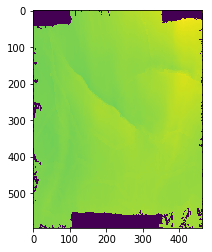

In [37]:
plt.imshow(horizon)
plt.show()

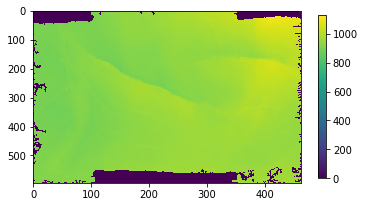

In [41]:
plt.imshow(horizon, aspect=0.5)
plt.colorbar(shrink=0.75)  # shrink makes the colourbar a bit shorter
plt.show()

In [46]:
plt.set_cmap("cubehelix_r")

In [58]:
# 为了去掉途中的 NAN 值，利用np.percentile来找到合适的min和max，这样就可以在
# 图中排除掉 零值
vmin = np.percentile(horizon[horizon > 0], 1)
vmax = np.percentile(horizon[horizon > 0], 99)
print("min {0}, max {1}".format(vmin, vmax))

min 891.804814338684, max 1065.9542727470366


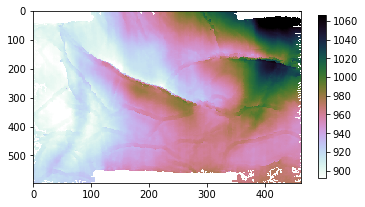

In [59]:
plt.imshow(horizon, aspect=0.5, vmin=vmin, vmax=vmax)
plt.colorbar(shrink=0.75)  # shrink makes the colourbar a bit shorter
plt.show()

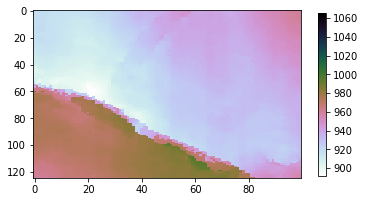

In [49]:
# 放大一部分
plt.imshow(horizon[200:325,200:300], aspect=0.5, vmin=vmin, vmax=vmax)
plt.colorbar(shrink=0.75)  # shrink makes the colourbar a bit shorter
plt.show()

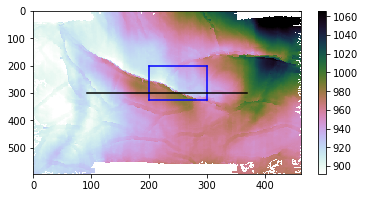

In [64]:
# 将放大的部分在大图上标示出来
plt.figure(figsize=(6, 3))
plt.imshow(horizon, vmin=vmin, vmax=vmax)
plt.plot([200, 300], [200, 200], 'b')
plt.plot([200, 300], [325, 325], 'b')
plt.plot([200, 200], [200, 325], 'b')
plt.plot([300, 300], [325, 200], 'b')
plt.axhline(y=300, xmin=0.2, xmax=0.8, color='k') # another way to draw a line
plt.colorbar()
plt.axis("tight")
plt.show()

## 加入噪音

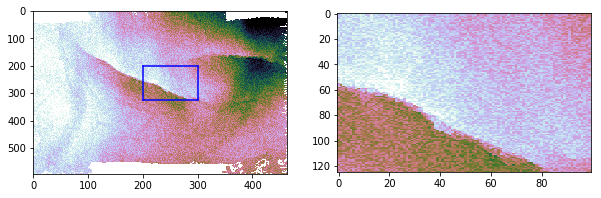

In [67]:
noise = np.random.uniform(-15, 15, horizon.shape)
noisy_horizon = horizon + noise

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(noisy_horizon, aspect=0.5, vmin=vmin, vmax=vmax)
plt.plot([200, 300], [200, 200], 'b')
plt.plot([200, 300], [325, 325], 'b')
plt.plot([200, 200], [200, 325], 'b')
plt.plot([300, 300], [325, 200], 'b')

plt.subplot(1, 2, 2)
plt.imshow(noisy_horizon[200:325, 200:300], aspect=0.5, vmin=vmin, vmax=vmax)

plt.show()

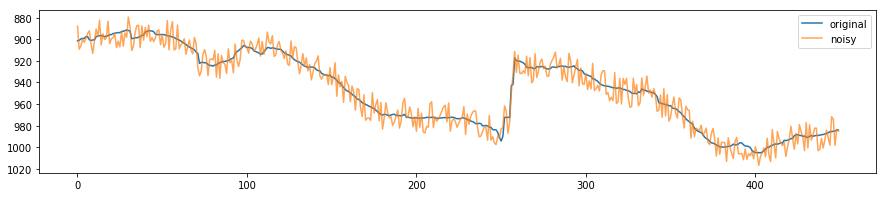

In [68]:
# 抽取一条线
plt.figure(figsize=(15,3))
plt.plot(horizon[300,:450])
plt.plot(noisy_horizon[300,:450], alpha=0.7) # reduce the opacity a bit with alpha
plt.legend(('original', 'noisy'))
plt.gca().invert_yaxis()  # show two-way time increasing downwards
plt.show()

## 卷积

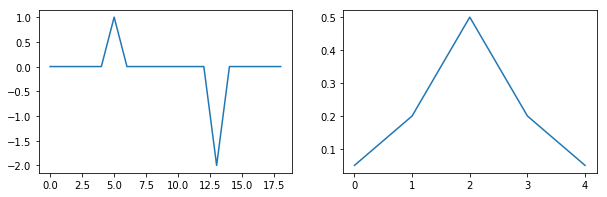

In [70]:
# 1-D example
my_spikes = np.zeros(19)
my_spikes[5] = 1
my_spikes[13] = -2

my_filter = np.array([0.05, 0.2, 0.5, 0.2, 0.05])

x = np.arange(len(my_spikes)) # for the plot

plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.plot(my_spikes)
plt.subplot(1,2,2)
plt.plot(my_filter)
plt.show()

[ 0.    0.05  0.2   0.5   0.2   0.05  0.    0.    0.   -0.1  -0.4  -1.   -0.4
 -0.1   0.  ]


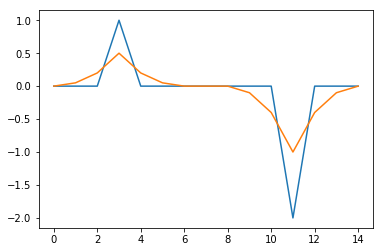

In [73]:
# 做卷积
result = np.zeros_like(my_spikes[2:-2])  # Copy the 3 to the (n-2)th elements of the array
for i in np.arange(len(result)):
    for j in np.arange(len(my_filter)):
        result[i] += my_spikes[(i + 2) +  (j - 2)] * my_filter[j]

print(result)

plt.plot(my_spikes[2:-2])
plt.plot(result)
plt.show()

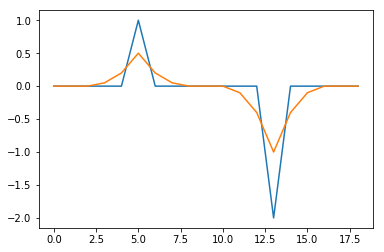

In [80]:
plt.plot(my_spikes)
plt.plot(np.convolve(my_spikes, my_filter)[2:-2])
plt.show()

## 建立卷积核

也即是卷积算子,滤波算子

从最简单的滤波器开始： 3X3 均值滤波

In [96]:
kernel = np.ones((3, 3)) / 9

print(kernel)

[[ 0.11111111  0.11111111  0.11111111]
 [ 0.11111111  0.11111111  0.11111111]
 [ 0.11111111  0.11111111  0.11111111]]


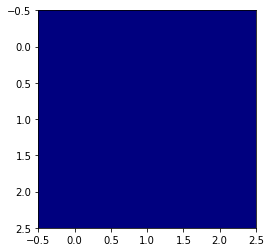

In [90]:
plt.imshow(kernel, cmap=plt.get_cmap('jet'), interpolation='nearest')
plt.show()

## 对数据做光滑

要对数据应用这个滤波器，我们需要

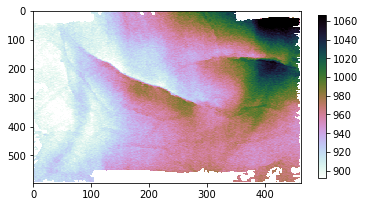

In [106]:
# make an empty array the same shape as the input
output = np.zeros_like(horizon) 

# 这里的卷积没有考虑边缘值。且因为kernel对称，也没有翻转kernel
for x in range(inlines - 2):
    for y in range(xlines - 2):
        sum_at_this_stop = 0
        for i in range(3):
            for j in range(3):
                horizon_value = noisy_horizon[(x+1)+(i-1),(y+1)+(j-1)]
                kernel_value = kernel[i,j]
                sum_at_this_stop += kernel_value * horizon_value
        output[x+1,y+1] = sum_at_this_stop

plt.imshow(output, aspect=0.5, vmin=vmin, vmax=vmax)
plt.colorbar(shrink=0.75)
plt.show()

In [110]:
print(kernel.shape)

(3, 3)


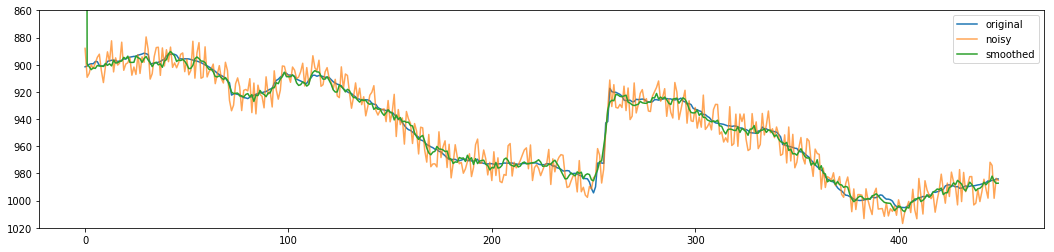

In [114]:
plt.figure(figsize=(18,4))
plt.plot(horizon[300,:450])
plt.plot(noisy_horizon[300,:450], alpha=0.7)
plt.plot(output[300,:450])
plt.ylim((860,1020))
plt.legend(('original', 'noisy', 'smoothed'))
plt.gca().invert_yaxis()
plt.savefig('Smoothing_result_new.pdf', bbox_inches='tight')
plt.show()

从图中可以明星的看出，由于卷积中没有考虑图像边缘，得到的结果开始的采样点不正常

## 快速卷积

Scipy 中提供了二维卷积

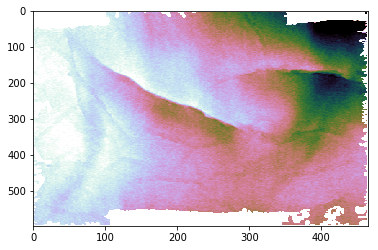

In [115]:
import scipy.signal
new_output = scipy.signal.convolve2d(noisy_horizon, kernel)

plt.imshow(new_output, aspect=0.5, vmin=vmin, vmax=vmax)
plt.show()

除此之外，还有另外的方法来获得卷积。

卷积等价于傅立叶系数的乘积。所以我们可以将horizon的kernel的傅里叶变换相乘，然后对结果取傅立叶反变换得到结果。

A convolution is equivalent to a multiplication of Fourier coefficients. So we can take Fourier transforms of the kernel and the horizon, multiply them, and take the inverse Fourier transform to get our result.

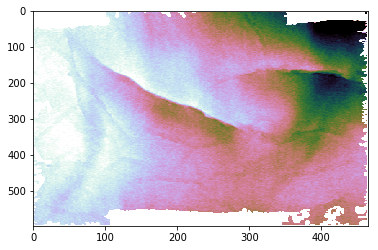

In [116]:
fft_output = scipy.signal.fftconvolve(noisy_horizon, kernel)

plt.imshow(fft_output, aspect=0.5, vmin=vmin, vmax=vmax)
plt.show()

In [117]:
# 速度测试
%timeit new_output = scipy.signal.convolve2d(noisy_horizon, kernel)
%timeit fft_output = scipy.signal.fftconvolve(noisy_horizon, kernel)

7.99 ms ± 102 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
18.1 ms ± 372 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## 更多卷积核


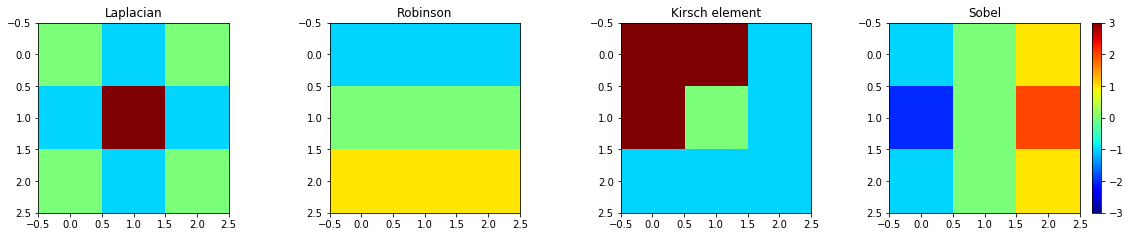

In [82]:
laplacian = np.array([[0, -1,  0],
                         [-1,  4,  -1],
                         [0, -1,  0]])

robinson = np.array([[-1, -1, -1],
                        [ 0,  0,  0],
                        [ 1,  1,  1]])

kirsch = np.array([[ 3,   3,  -1],
                      [ 3,   0,  -1],
                      [-1,  -1,  -1]])

sobel = np.array([[-1, 0, 1],
                     [-2, 0, 2],
                     [-1, 0, 1]])

plt.figure(figsize=(20,3.5))
plt.subplot(1,4,1)
plt.imshow(laplacian, cmap=plt.get_cmap('jet'), interpolation='nearest', vmin=-3, vmax=3)
plt.title('Laplacian')
plt.subplot(1,4,2)
plt.imshow(robinson, cmap=plt.get_cmap('jet'), interpolation='nearest', vmin=-3, vmax=3)
plt.title('Robinson')
plt.subplot(1,4,3)
plt.imshow(kirsch, cmap=plt.get_cmap('jet'), interpolation='nearest', vmin=-3, vmax=3)
plt.title('Kirsch element')
plt.subplot(1,4,4)
plt.imshow(sobel, cmap=plt.get_cmap('jet'), interpolation='nearest', vmin=-3, vmax=3)
plt.title('Sobel')
plt.colorbar(ticks=[-3, -2, -1, 0, 1, 2, 3])
plt.show()

/home/pzhang/.local/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in sqrt
/home/pzhang/.local/lib/python3.5/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in sqrt
/home/pzhang/.local/lib/python3.5/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in sqrt


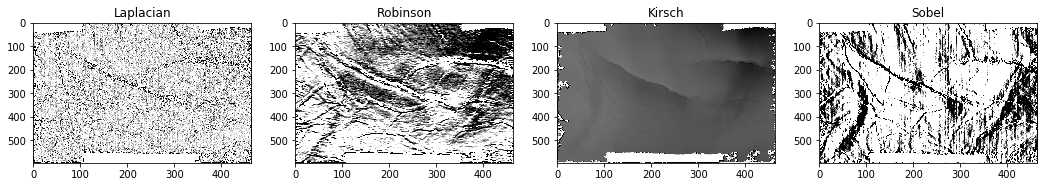

In [120]:
shaded_relief = scipy.signal.convolve2d(horizon, laplacian)
robinson_relief = scipy.signal.convolve2d(horizon, robinson)
kirsch_element = scipy.signal.convolve2d(horizon, kirsch)
sobel_relief = scipy.signal.convolve2d(horizon, sobel)

plt.figure(figsize=(18,3))
plt.subplot(1,4,1)
plt.imshow(shaded_relief**0.5, cmap=plt.get_cmap('Greys'), vmax=2, aspect=0.5)
plt.title('Laplacian')
plt.subplot(1,4,2)
plt.imshow(robinson_relief**0.5, cmap=plt.get_cmap('Greys'), vmax=2, aspect=0.5)
plt.title('Robinson')
plt.subplot(1,4,3)
plt.imshow(kirsch_element**2, cmap=plt.get_cmap('Greys'), vmax=20000000, aspect=0.5)
plt.title('Kirsch')
plt.subplot(1,4,4)
plt.imshow(sobel_relief**0.5, cmap=plt.get_cmap('Greys'), vmax=2, aspect=0.5)
plt.title('Sobel')
plt.show()

`scipy.signal` 库中包含了很多的滤波器。中值滤波是最常见的滤波器。

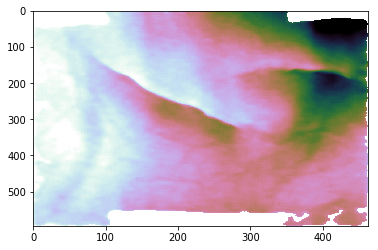

In [122]:
median_output = scipy.signal.medfilt2d(noisy_horizon, 11)

plt.imshow(median_output, aspect=0.5, vmin=vmin, vmax=vmax)
plt.show()

高斯滤波器利用相关包也容易实现,
ndimage (n-dimensional image processing). The second parameter is the standard deviation, which controls how smooth the output is.

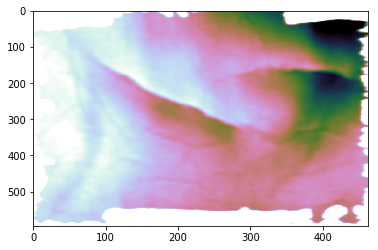

In [130]:
import scipy.ndimage

gaussian = scipy.ndimage.filters.gaussian_filter(noisy_horizon, 3.0)

plt.imshow(gaussian, aspect=0.5, vmin=vmin, vmax=vmax)
plt.show()

我们也可以自己构造一个Gaussian卷积核

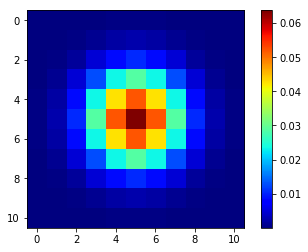

In [126]:
def gaussian_kernel(size, size_y=None):
    size = int(size)
    if not size_y:
        size_y = size
    else:
        size_y = int(size_y)
    x, y = np.mgrid[-size:size+1, -size_y:size_y+1]
    g = np.exp(-(x**2/float(size)+y**2/float(size_y)))
    return g / g.sum()

# Make the Gaussian by calling the function
gaussian_kernel_array = gaussian_kernel(5)

plt.imshow(gaussian_kernel_array, cmap=plt.get_cmap('jet'), interpolation='nearest')
plt.colorbar()
plt.show()

最后我们可以比较各个滤波器的效果：


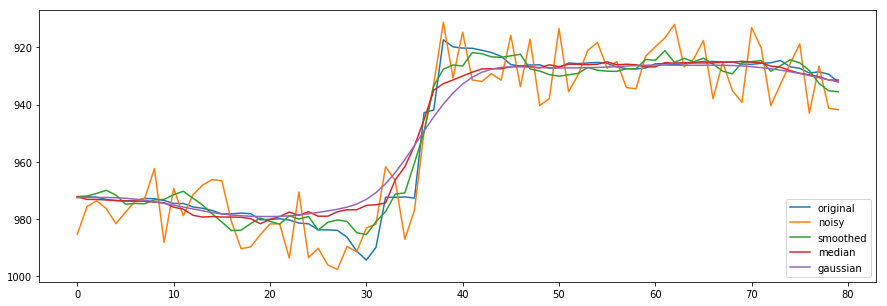

In [131]:
plt.figure(figsize=(15,5))
plt.plot(horizon[300,220:300])
plt.plot(noisy_horizon[300,220:300])
plt.plot(output[300,220:300])
plt.plot(median_output[300,220:300])
plt.plot(gaussian[300,220:300])
plt.legend(('original', 'noisy', 'smoothed', 'median', 'gaussian'), loc=4)
plt.gca().invert_yaxis()
plt.show()